In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os

import skimage.exposure 
import skimage.transform 

In [2]:
path = "../data/stage_1_train/"
names = os.listdir(path)

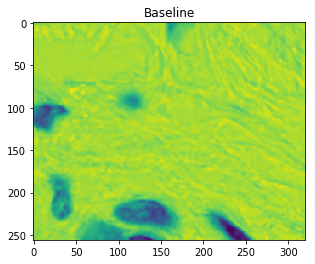

In [3]:
base_img = np.load("../data/stage_1_processed/train/train_01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf.npy")[:,:,:]
plt.title("Baseline")
plt.imshow(base_img[:,:,0])
plt.show()

# # resize using cv2.resize
# imgx3_simple = cv2.resize(base_img, (base_img.shape[1]*3,base_img.shape[0]*3),interpolation=cv2.INTER_AREA)
# plt.figure(figsize=(12,12))
# plt.title("The Wrong Way: Saw Tooth")

In [4]:
def resize_smooth(img, ratios):       
    resized_img = np.zeros((int(img.shape[0] * ratios[0]), int(img.shape[1] * ratios[1]), img.shape[2]))
    print(img.shape)
    print(resized_img.shape)
    for i in range(1,img.shape[2]):
        layer = np.zeros((int(img.shape[0] * ratios[0]), int(img.shape[1] * ratios[1])))
        _, cnts_base, hierarchy = cv2.findContours(img[:,:,i].copy().astype("uint8"), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
        new_cnts = []
        for c in cnts_base:
            c = np.round_(c * np.array(ratios[::-1]).reshape((1,1,2))).astype(int)
            new_cnts.append(c)
        
        cv2.drawContours(layer,new_cnts,-1,1,-1)
        resized_img[:,:,i] = layer.astype(int)
      
    main_layer = cv2.resize(img[:,:,0], (resized_img.shape[1], resized_img.shape[0]),interpolation=cv2.INTER_NEAREST)
    print(main_layer.shape)
    resized_img[:,:,0] = main_layer
    return resized_img

(256, 320, 3)
(256, 160, 3)
(256, 160)


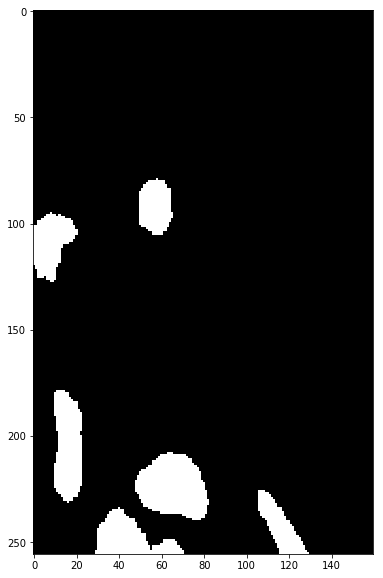

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(resize_smooth(base_img, [1,0.5])[:,:,1], cmap='gray')
plt.show()

In [6]:
def generate_affine(im, zoom=1.0, rotation=0, shear=0, translation=(0, 0)):
    center_shift = np.array((im.shape[0], im.shape[1])) / 2
    tform_center = skimage.transform.SimilarityTransform(translation=-center_shift)
    tform_uncenter = skimage.transform.SimilarityTransform(translation=center_shift)

    tform_augment = skimage.transform.AffineTransform(scale=(1/zoom, 1/zoom), rotation=np.deg2rad(rotation), shear=np.deg2rad(shear), translation=translation)
    tform = tform_center + tform_augment + tform_uncenter

    return tform

def affine(im, tform): 
    new_im = skimage.transform.warp(im, tform)
    
    new_im[:,:,0] = new_im[:,:,0] / 255
    for i in range(1, im.shape[2]):
        new_im[:,:,i] = (cv2.morphologyEx(new_im[:,:,i], cv2.MORPH_CLOSE, np.ones((3,3))) > 0).astype(int)

    return new_im

(256, 320, 3)
(256, 160, 3)
(256, 160)


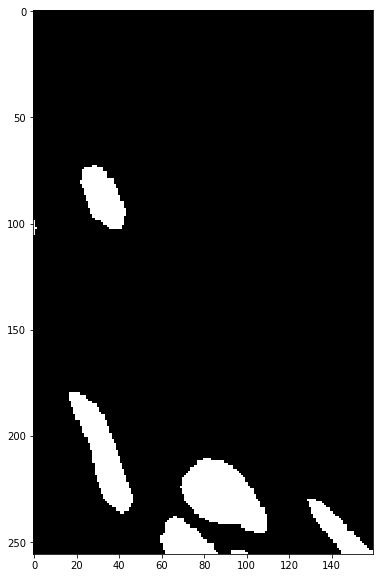

In [7]:
tform = generate_affine(base_img, shear=20)

plt.figure(figsize=(10,10))
plt.imshow(affine(resize_smooth(base_img, [1,0.5]),  tform)[:,:,1], cmap='gray')
plt.show()

In [8]:
class Transformation: 
    def __init__(self,
                 im,
                log=0,
                sigmoid=0,
                rotation=0,
                shear=0,
                ratios=np.array([1,1]),
                vertical_flip=0,
                horizontal_flip=0):
        self.log = log
        self.sigmoid = sigmoid
        self.affine = generate_affine(im, rotation=rotation,shear=shear)
        self.ratios = ratios
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
    
    def generate_random_transformation(self, im):
        self.log = np.random.randint(0,2)
        self.sigmoid = np.random.randint(0,2)
        self.affine = generate_affine(im, rotation=np.random.randint(-20,20),shear=np.random.randint(-20,20))
        self.ratios = (np.random.random(2) + 1) / 2
        self.vertical_flip = np.random.randint(0,2)
        self.horizontal_flip = np.random.randint(0,2)
        
        return self
        
    def generate_geometrical(self, im):
        self.generate_random_transformation(im)
        self.log = 0
        self.sigmoid = 0
        
        return self
        
    def apply(self, im):
        ## BE CAREFUL APPLY ONLY ON THE SAME IMAGE
#         if self.log:
#             im[:,:,0] = skimage.exposure.adjust_log(im[:,:,0])
#         if self.sigmoid:
#             im[:,:,0] = skimage.exposure.adjust_sigmoid(im[:,:,0])
            
        im = affine(im, self.affine)
        im = resize_smooth(im, self.ratios)
        
        if self.vertical_flip:
            im = im[::-1,:,:]
                
        if self.horizontal_flip:
            im = im[:,::-1,:]
            
        im[:,:,0] /= im[:,:,0].max()
        return im
    
    def apply_inverse(self, im):
        ##TODO apply log and sigmoid
        
        if self.vertical_flip:
            im = im[::-1,:,:]
                
        if self.horizontal_flip:
            im = im[:,::-1,:]
            
        im = resize_smooth(im, 1 / self.ratios)
        im = affine(im, self.affine.inverse)
        
        
        return im
    

    

In [9]:
trnsf = Transformation(base_img,ratios=np.array([1.1,0.7]), rotation=10, shear=10, vertical_flip=1)

In [10]:
trnsf.ratios

array([1.1, 0.7])

In [11]:
1 / trnsf.ratios

array([0.90909091, 1.42857143])

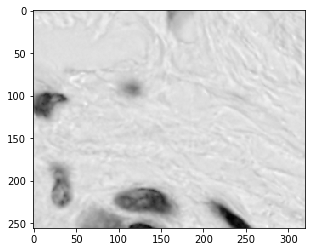

In [12]:
plt.imshow(base_img[:,:,0],cmap='gray')
plt.show()

(256, 320, 3)
(281, 224, 3)
(281, 224)


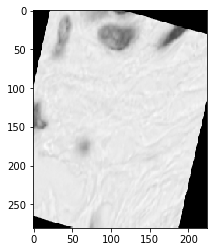

In [13]:
plt.imshow(trnsf.apply(base_img)[:,:,0],cmap='gray')
plt.show()

(256, 320, 3)
(281, 224, 3)
(281, 224)
(281, 224, 3)
(255, 320, 3)
(255, 320)


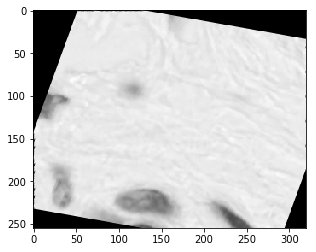

In [14]:
plt.imshow(trnsf.apply_inverse(trnsf.apply(base_img))[:,:,0],cmap='gray')
plt.show()

In [24]:
from skimage.morphology import label 

In [19]:
def iou_at_thresholds(target_mask, pred_mask, thresholds=np.arange(0.5,1,0.05)):
    '''Returns True if IoU is greater than the thresholds.'''
    intersection = np.logical_and(target_mask, pred_mask)
    union = np.logical_or(target_mask, pred_mask)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou > thresholds
def calculate_average_precision(target_masks, pred_masks, thresholds=np.arange(0.5,1,0.05)):
    '''Calculates the average precision over a range of thresholds for one observation (with a single class).'''
    iou_tensor = np.zeros([len(thresholds), len(pred_masks), len(target_masks)])

    for i, p_mask in enumerate(pred_masks):
        for j, t_mask in enumerate(target_masks):
            iou_tensor[:, i, j] = iou_at_thresholds(t_mask, p_mask, thresholds)

    TP = np.sum((np.sum(iou_tensor, axis=2) == 1), axis=1)
    FP = np.sum((np.sum(iou_tensor, axis=1) == 0), axis=1)
    FN = np.sum((np.sum(iou_tensor, axis=2) == 0), axis=1)

    precision = TP / (TP + FP + FN)

    return np.mean(precision)

In [27]:
calculate_average_precision([x for x in prob_to_masks(trnsf.apply_inverse(trnsf.apply(base_img))[:,:,1])],[x for x in prob_to_masks(base_img[:-1,:,1])])

(256, 320, 3)
(281, 224, 3)
(281, 224)
(281, 224, 3)
(255, 320, 3)
(255, 320)


0.3411111111111111

In [21]:
def prob_to_masks(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield (lab_img==i).astype(int)

In [26]:
len([x for x in prob_to_masks(base_img[:-1,:,1])])

6

(256, 320, 3)
(281, 224, 3)
(281, 224)
(281, 224, 3)
(255, 320, 3)
(255, 320)


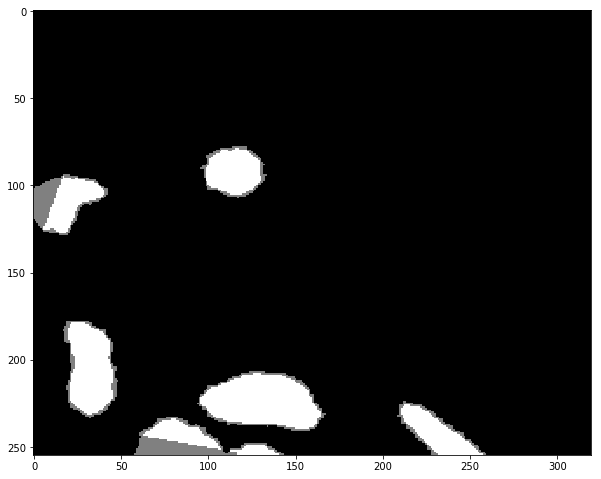

In [15]:
plt.figure(figsize = (10,10))
plt.imshow(trnsf.apply_inverse(trnsf.apply(base_img))[:,:,1] + base_img[:-1,:,1], cmap='gray')
plt.show()

In [16]:
trnsf.apply(base_img)[:,:,1].max()

(256, 320, 3)
(281, 224, 3)
(281, 224)


1.0